<a href="https://colab.research.google.com/github/ZhengyiGuo2002/CSDM-code/blob/main/CSDM_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from diffusers import UNet1DModel
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
logret_month = pd.read_csv("monthly_stock_logret.csv", index_col=0)
logret_month.index = pd.to_datetime(logret_month.index)
logret_month

,AAPL,AMZN,COST,CVX,GOOGL,JPM,KO,MCD,NVDA,UNH
2010-09-01,-0.027268,0.116755,0.022497,0.016630,-0.051896,-0.065134,0.039144,0.074167,0.022594,0.067919
2010-10-01,0.120969,0.148561,0.118340,0.065295,0.132635,0.027957,0.038641,0.005085,0.188508,0.087234
2010-11-01,0.073870,0.056102,-0.024362,-0.006120,0.157044,-0.035184,0.042877,0.038748,0.059017,0.019011
2010-12-01,0.039388,0.082434,0.076487,0.023751,-0.085948,0.019321,0.054202,0.025740,0.165712,0.042294
2011-01-01,0.019282,0.019353,0.055522,0.098383,0.051154,0.106094,0.016403,-0.032428,0.080421,-0.039004
...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-0.080253,-0.099526,-0.094138,0.060484,-0.079602,-0.082634,0.016578,0.022801,-0.125738,0.100845
2025-05-01,-0.045230,-0.010304,0.045712,-0.212430,0.026574,0.019310,-0.008103,0.000032,0.013168,-0.266648
2025-06-01,-0.058925,0.074983,0.041656,0.015331,0.062716,0.067006,0.011298,0.000669,0.191227,-0.283034
2025-07-01,0.034114,0.072658,-0.053533,0.062868,0.024803,0.095345,0.001103,-0.047879,0.126229,0.084272


In [ ]:
macro = pd.read_csv("2025-07-MD.csv", skiprows=[1])
macro['sasdate'] = pd.to_datetime(macro['sasdate'])
macro = macro.set_index('sasdate')
macro.index.name = None
macro = macro.ffill()
macro

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,17689.23968,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,17819.01912,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,17967.91336,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,17978.97983,23.1981,24.1903,22.8957,32.4019,19.5466,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18119.82573,23.5476,24.3911,23.1161,32.5567,19.9445,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-01,20239.819,16428.6,122.264,1.553661e+06,711757.00000,103.9397,101.8163,101.5574,102.8966,102.6932,...,120.617,130.965,31.98,36.66,28.64,64.7,556936.50,941205.75,5372.8288,17.0705
2025-03-01,20366.533,16522.6,123.095,1.574621e+06,722572.00000,103.6682,101.6337,101.2570,101.8971,103.1034,...,119.757,131.283,32.19,36.80,28.88,57.0,554966.69,938997.88,5416.8359,21.6579
2025-04-01,20496.445,16552.2,123.162,1.567412e+06,721789.00000,103.6912,101.3245,100.9047,101.4440,101.0385,...,119.653,131.516,32.22,36.96,28.78,52.2,554161.39,939827.21,5486.3090,32.5116
2025-05-01,20382.296,16522.8,122.914,1.562061e+06,715541.00000,103.6602,101.3206,101.0105,101.4140,102.8030,...,119.775,131.792,32.31,37.08,28.87,52.2,551973.30,938172.31,5523.5085,20.3620


In [ ]:
macro_aligned = macro.sort_index().reindex(logret_month.index).ffill()
macro_aligned
macro_aligned.to_csv('macro_aligned.csv')

In [ ]:
scaler = StandardScaler()
macro_scaled = scaler.fit_transform(macro_aligned)

pca = PCA()
macro_pca = pca.fit_transform(macro_scaled)

macro_pca_df = pd.DataFrame(
    macro_pca,
    index=macro_aligned.index,
    columns=[f"PC{i+1}" for i in range(macro_pca.shape[1])]
)

macro_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126
2010-09-01,-14.087288,-4.866688,3.247625,1.573413,1.172293,-3.732404,1.839048,-0.061179,0.018602,-0.526002,...,-0.000085,0.000043,0.000017,1.061420e-15,1.266321e-15,-3.389832e-16,-1.298628e-15,1.180460e-15,-1.397719e-15,-1.481162e-15
2010-10-01,-14.044244,-4.978760,3.632710,1.539055,0.768315,-3.755295,1.567445,-0.490484,0.071746,-0.801697,...,0.000097,-0.000091,-0.000035,-2.103808e-15,-9.991665e-16,-2.139501e-15,1.613082e-15,-1.939958e-16,2.285017e-15,1.963486e-15
2010-11-01,-14.033453,-4.977055,3.793262,1.611086,1.086938,-3.598739,1.683274,-0.259054,-0.154557,-1.087353,...,-0.000112,0.000070,0.000002,1.989166e-15,-3.512830e-16,2.037325e-15,-4.961836e-16,-3.039406e-16,-7.218398e-16,1.043747e-15
2010-12-01,-13.383117,-4.060487,4.517853,0.705795,1.321253,-3.385375,2.472514,1.306792,-0.126426,0.273424,...,0.000066,-0.000048,-0.000004,1.849094e-15,5.853796e-16,1.567894e-16,1.061554e-15,-2.432215e-15,2.982722e-16,1.401000e-15
2011-01-01,-13.016383,-4.324984,4.985460,0.456669,1.188287,-3.092318,2.435169,0.929494,0.095722,-0.145240,...,0.000129,0.000055,0.000007,-1.764440e-15,8.549386e-16,-5.548034e-16,-1.669984e-15,2.809549e-15,-4.558168e-16,3.012833e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,13.623983,-2.090313,4.539515,1.668049,-1.719362,0.630942,1.574987,-0.499440,0.467250,1.804652,...,0.000106,0.000055,0.000018,5.280165e-16,7.066635e-16,5.980808e-17,7.504958e-16,-3.418337e-16,3.710549e-16,1.581976e-15
2025-05-01,13.804233,-1.667166,5.471383,1.598782,-1.860009,1.474090,1.291471,0.304707,0.280075,-0.765088,...,0.000188,-0.000153,0.000009,1.443654e-15,-5.594142e-16,1.821797e-16,-1.295917e-15,-3.632856e-16,8.283200e-16,1.507127e-16
2025-06-01,13.834161,-1.639953,5.370937,1.545006,-2.064392,0.844473,1.763449,0.545831,0.344409,0.473041,...,-0.000080,0.000028,-0.000003,4.387040e-16,5.905565e-17,1.607774e-16,-4.849430e-17,1.132305e-15,-5.061604e-16,8.133355e-17
2025-07-01,13.834161,-1.639953,5.370937,1.545006,-2.064392,0.844473,1.763449,0.545831,0.344409,0.473041,...,-0.000080,0.000028,-0.000003,-1.153841e-16,-4.605230e-17,1.022969e-16,-1.340342e-16,-5.322262e-16,3.782054e-16,6.449467e-16


In [ ]:
import statsmodels.api as sm

y = logret_month.mean(axis=1)

X = macro_pca_df.iloc[:, :6].loc[y.index]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("Coefficients:")
print(model.params)
print("\nR²:", model.rsquared)

Coefficients:
const    0.015933
PC1     -0.000186
PC2     -0.000178
PC3     -0.000657
PC4      0.000189
PC5     -0.004762
PC6     -0.003618
dtype: float64

R²: 0.07517607317545016


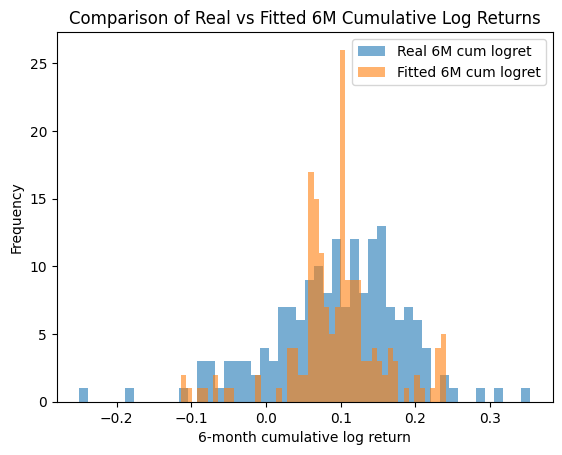

In [ ]:
y_hat = model.predict(X)

y_cum6     = y.rolling(6).sum()
yhat_cum6  = y_hat.rolling(6).sum()

plt.hist(y_cum6.dropna(), bins=50, alpha=0.6, label="Real 6M cum logret")
plt.hist(yhat_cum6.dropna(), bins=50, alpha=0.6, label="Fitted 6M cum logret")
plt.legend()
plt.xlabel("6-month cumulative log return")
plt.ylabel("Frequency")
plt.title("Comparison of Real vs Fitted 6M Cumulative Log Returns")
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


/tmp/ipython-input-730823338.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tensor = torch.tensor(y_scaled, device = device).view(-1, 1)


Epoch 10, Loss 0.834219
Epoch 20, Loss 0.687674
Epoch 30, Loss 0.624219
Epoch 40, Loss 0.581832
Epoch 50, Loss 0.536863
Epoch 60, Loss 0.491669
Epoch 70, Loss 0.457240
Epoch 80, Loss 0.414999
Epoch 90, Loss 0.363420
Epoch 100, Loss 0.357391
Epoch 110, Loss 0.306037
Epoch 120, Loss 0.307050
Epoch 130, Loss 0.277605
Epoch 140, Loss 0.236471
Epoch 150, Loss 0.248643
Epoch 160, Loss 0.209010
Epoch 170, Loss 0.190132
Epoch 180, Loss 0.210565
Epoch 190, Loss 0.176709
Epoch 200, Loss 0.198216
Epoch 210, Loss 0.168332
Epoch 220, Loss 0.144001
Epoch 230, Loss 0.217437
Epoch 240, Loss 0.142006
Epoch 250, Loss 0.123512
Epoch 260, Loss 0.109478
Epoch 270, Loss 0.098729
Epoch 280, Loss 0.109086
Epoch 290, Loss 0.113712
Epoch 300, Loss 0.082469


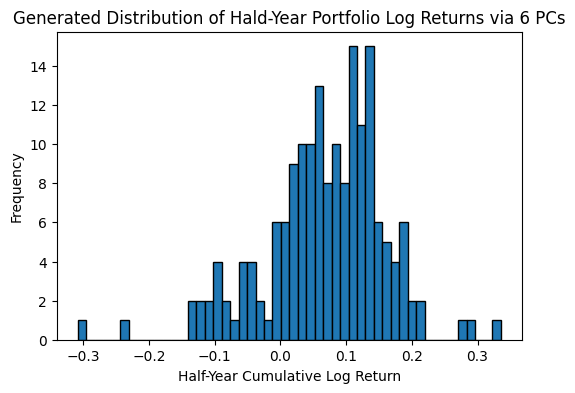

Predicted 120-Day Cumulative Log Returns Statistics:
Mean      : 0.067750
Std Dev   : 0.091250
1% quant  : -0.163454
5% quant  : -0.100542
10% quant : -0.052502
25% quant : 0.019476
Median    : 0.076247
75% quant : 0.128082
95% quant : 0.187365


In [ ]:
import torch.optim as optim
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# X = PCA first 6 factors, y = logret
X = macro_pca_df.iloc[:, :6].values.astype(np.float32)  # shape (T, 6)
y = y.astype(np.float32)

y_mean = y.mean()
y_std = y.std()
y_scaled = (y - y_mean) / y_std

X_tensor = torch.tensor(X, device = device)
y_tensor = torch.tensor(y_scaled, device = device).view(-1, 1)

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model_FNN = MLP(in_dim=X.shape[1], out_dim=1).to(device)
optimizer = optim.Adam(model_FNN.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

# training
for epoch in range(300):
    optimizer.zero_grad()
    pred = model_FNN(X_tensor)
    loss = loss_fn(pred, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss {loss.item():.6f}")

# prediction
y_pred = model_FNN(X_tensor).detach().cpu().numpy().flatten()
y_pred = y_pred * y_std + y_mean

# sliding window consecutive 120-day portfolio return
window = 6
port_returns = []
for start in range(len(y_pred) - window + 1):
    window_pred = y_pred[start:start+window]
    port_cum = np.sum(window_pred)
    port_returns.append(port_cum)

# histogram
plt.figure(figsize=(6,4))
plt.hist(port_returns, bins=50, edgecolor='black')
plt.xlabel("Half-Year Cumulative Log Return")
plt.ylabel("Frequency")
plt.title("Generated Distribution of Hald-Year Portfolio Log Returns via 6 PCs")
plt.show()

mean_val = np.mean(port_returns)
std_val = np.std(port_returns)
q01, q05, q10, q25, q50, q75, q95 = np.percentile(port_returns, [1,5,10,25,50,75,95])

print("Predicted 120-Day Cumulative Log Returns Statistics:")
print(f"Mean      : {mean_val:.6f}")
print(f"Std Dev   : {std_val:.6f}")
print(f"1% quant  : {q01:.6f}")
print(f"5% quant  : {q05:.6f}")
print(f"10% quant : {q10:.6f}")
print(f"25% quant : {q25:.6f}")
print(f"Median    : {q50:.6f}")
print(f"75% quant : {q75:.6f}")
print(f"95% quant : {q95:.6f}")

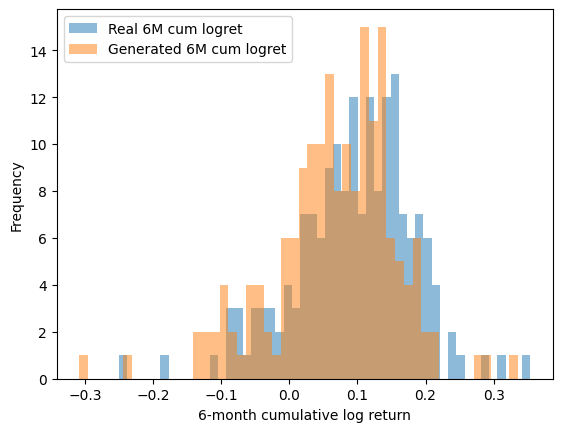

Generated 6-month Cumulative Log Returns Statistics:
Mean      : 0.067750
Std Dev   : 0.091250
1% quant  : -0.163454
5% quant  : -0.100542
10% quant : -0.052502
25% quant : 0.019476
Median    : 0.076247
Real 6-month Cumulative Log Returns Statistics:
Mean      : 0.094319
Std Dev   : 0.088271
1% quant  : -0.126466
5% quant  : -0.066397
10% quant : -0.026704
25% quant : 0.041709
Median    : 0.103768


In [ ]:
plt.hist(y_cum6.dropna(), bins=50, alpha=0.5, label="Real 6M cum logret")
plt.hist(port_returns, bins=50, alpha=0.5, label="Generated 6M cum logret")
plt.legend()
plt.xlabel("6-month cumulative log return")
plt.ylabel("Frequency")
plt.show()

mean_val = np.mean(port_returns)
std_val = np.std(port_returns)
q01, q05, q10, q25, q50 = np.percentile(port_returns, [1,5,10,25,50])

print("Generated 6-month Cumulative Log Returns Statistics:")
print(f"Mean      : {mean_val:.6f}")
print(f"Std Dev   : {std_val:.6f}")
print(f"1% quant  : {q01:.6f}")
print(f"5% quant  : {q05:.6f}")
print(f"10% quant : {q10:.6f}")
print(f"25% quant : {q25:.6f}")
print(f"Median    : {q50:.6f}")


mean_val = np.mean(y_cum6.dropna())
std_val = np.std(y_cum6.dropna())
q01, q05, q10, q25, q50 = np.percentile(y_cum6.dropna(), [1,5,10,25,50])

print("Real 6-month Cumulative Log Returns Statistics:")
print(f"Mean      : {mean_val:.6f}")
print(f"Std Dev   : {std_val:.6f}")
print(f"1% quant  : {q01:.6f}")
print(f"5% quant  : {q05:.6f}")
print(f"10% quant : {q10:.6f}")
print(f"25% quant : {q25:.6f}")
print(f"Median    : {q50:.6f}")

Markowitz Efficient frontier

In [ ]:
set_seed(42)

X = macro_pca_df.iloc[:, :6].values.astype(np.float32)
y = logret_month.values.astype(np.float32)

X_tensor = torch.tensor(X, device = device)
y_tensor = torch.tensor(y, device = device)

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model_FNN = MLP(in_dim=X.shape[1], out_dim=y.shape[1]).to(device)
optimizer = optim.Adam(model_FNN.parameters(), lr=4e-4)
loss_fn = nn.MSELoss()

# training
for epoch in range(300):
    optimizer.zero_grad()
    pred = model_FNN(X_tensor)
    loss = loss_fn(pred, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss {loss.item():.6f}")

# prediction
y_pred = model_FNN(X_tensor).detach().cpu().numpy()

Epoch 10, Loss 0.005203
Epoch 20, Loss 0.004719
Epoch 30, Loss 0.004382
Epoch 40, Loss 0.004135
Epoch 50, Loss 0.003955
Epoch 60, Loss 0.003764
Epoch 70, Loss 0.003584
Epoch 80, Loss 0.003558
Epoch 90, Loss 0.003368
Epoch 100, Loss 0.003147
Epoch 110, Loss 0.002971
Epoch 120, Loss 0.003051
Epoch 130, Loss 0.002776
Epoch 140, Loss 0.002526
Epoch 150, Loss 0.002544
Epoch 160, Loss 0.002343
Epoch 170, Loss 0.002459
Epoch 180, Loss 0.002181
Epoch 190, Loss 0.002074
Epoch 200, Loss 0.001976
Epoch 210, Loss 0.001872
Epoch 220, Loss 0.001817
Epoch 230, Loss 0.001894
Epoch 240, Loss 0.001737
Epoch 250, Loss 0.001577
Epoch 260, Loss 0.001677
Epoch 270, Loss 0.001674
Epoch 280, Loss 0.001378
Epoch 290, Loss 0.001313
Epoch 300, Loss 0.001271


/tmp/ipython-input-3359551644.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rets.append(float(mu.T @ w.value))


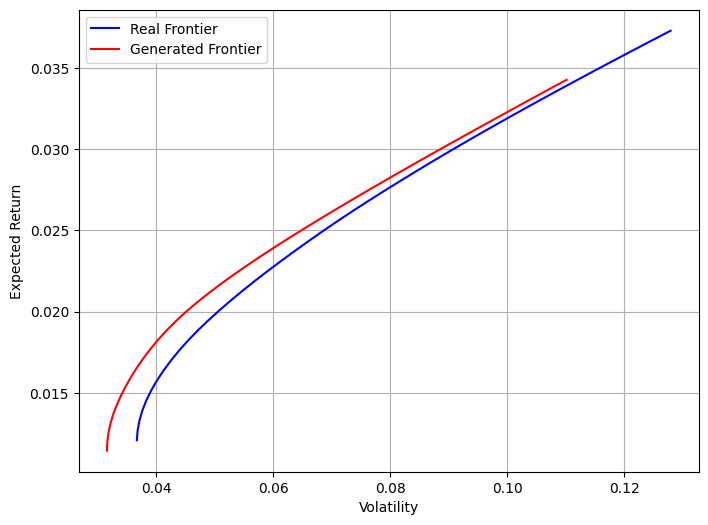

== GMVP 权重 (真实数据, 百分制) ==
0     0.00
1     4.74
2    17.83
3     1.61
4     9.47
5     1.45
6    27.99
7    25.34
8     0.00
9    11.56
dtype: float64
== GMVP 权重 (预测数据, 百分制) ==
0    -0.00
1     1.35
2    28.85
3    -0.00
4     6.05
5    -0.00
6    39.40
7    13.39
8    -0.00
9    10.96
dtype: float64


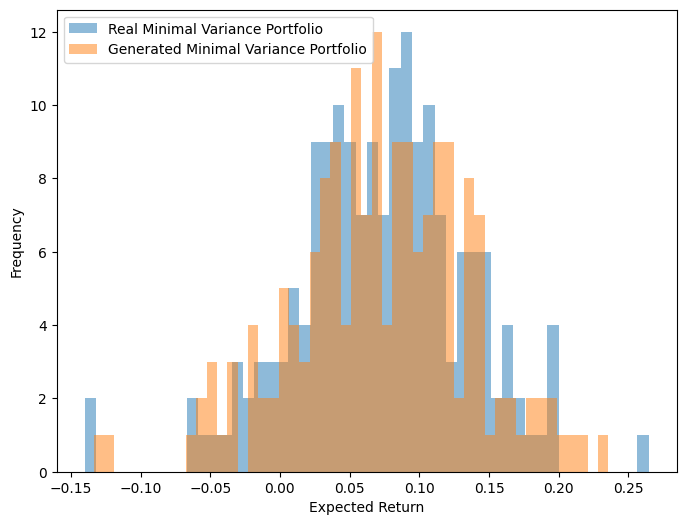

== 滚动收益统计量 (真实GMVP) ==
mean      0.072617
median    0.076322
std       0.061863
q1%      -0.085161
q5%      -0.027773
q10%     -0.002649
q25%      0.036547
dtype: float64
== 滚动收益统计量 (预测GMVP, 在真实收益上测算) ==
mean      0.072807
median    0.070077
std       0.064245
q1%      -0.079044
q5%      -0.038111
q10%     -0.007265
q25%      0.035150
dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

# real data
rets_real = logret_month.values   # (T,10)
mu_real = rets_real.mean(axis=0)  # (10,)
cov_real = np.cov(rets_real, rowvar=False)  # (10,10)

# prediction data
rets_pred = y_pred
mu_pred = rets_pred.mean(axis=0)
cov_pred = np.cov(rets_pred, rowvar=False)

# Markowitz optimization
def markowitz_frontier(mu, cov, n_points=50, short=False):
    n = len(mu)
    cov = (cov + cov.T) / 2
    mu = mu.reshape(-1,1)

    risks, rets, weights = [], [], []

    mu_min, mu_max = mu.min(), mu.max()
    target_returns = np.linspace(mu_min, mu_max, n_points)

    for target in target_returns:
        w = cp.Variable(n)
        risk = cp.quad_form(w, cov)
        constraints = [cp.sum(w) == 1,
                       mu.T @ w >= target]
        if not short:
            constraints.append(w >= 0)

        prob = cp.Problem(cp.Minimize(risk), constraints)
        prob.solve(solver=cp.SCS, verbose=False)

        if w.value is not None:
            risks.append(np.sqrt(risk.value))
            rets.append(float(mu.T @ w.value))
            weights.append(w.value)

    return np.array(risks), np.array(rets), weights

# efficient frontier
risk_real, ret_real, w_real = markowitz_frontier(mu_real, cov_real)
risk_pred, ret_pred, w_pred = markowitz_frontier(mu_pred, cov_pred)


plt.figure(figsize=(8,6))
plt.plot(risk_real, ret_real, 'b-', label="Real Frontier")
plt.plot(risk_pred, ret_pred, 'r-', label="Generated Frontier")
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.legend()
plt.grid(True)
plt.show()

# GMVP
idx_real = np.argmin(risk_real)
idx_pred = np.argmin(risk_pred)

w_gmvp_real = w_real[idx_real]
w_gmvp_pred = w_pred[idx_pred]

print("== GMVP weights (real data) ==")
print(pd.Series(w_gmvp_real*100, index=range(len(w_gmvp_real))).round(2))
print("== GMVP weights (predicted data) ==")
print(pd.Series(w_gmvp_pred*100, index=range(len(w_gmvp_pred))).round(2))

# 6-month rolling return
def rolling_portfolio_returns(rets, weights, window=6):
    port_ret = rets @ weights
    roll_sum = pd.Series(port_ret).rolling(window).sum().dropna()
    return roll_sum

roll_real = rolling_portfolio_returns(rets_real, w_gmvp_real, window=6)
roll_pred = rolling_portfolio_returns(rets_real, w_gmvp_pred, window=6)

plt.figure(figsize=(8,6))
plt.hist(roll_real, bins=50, alpha=0.5, label="Real Minimal Variance Portfolio")
plt.hist(roll_pred, bins=50, alpha=0.5, label="Generated Minimal Variance Portfolio")
plt.xlabel("Expected Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# ====
def stats_summary(x):
    return pd.Series({
        "mean": x.mean(),
        "median": x.median(),
        "std": x.std(),
        "q1%": x.quantile(0.01),
        "q5%": x.quantile(0.05),
        "q10%": x.quantile(0.10),
        "q25%": x.quantile(0.25),
    })

print("== rolling return statistics (real GMVP) ==")
print(stats_summary(roll_real))
print("== rolling return statistics (predicted GMVP) ==")
print(stats_summary(roll_pred))



Risk Parity

In [ ]:
import numpy as np
import cvxpy as cp

def risk_parity_weights_cvx(Sigma, b=None, eps=1e-8, solver="SCS", max_iters=5000):
    """
    Risk Parity / Risk Budgeting via convex program:
        min  0.5 * w^T Σ w  -  sum_i b_i * log(w_i)
        s.t. 1^T w = 1, w_i >= eps
    """
    Sigma = 0.5 * (Sigma + Sigma.T)
    n = Sigma.shape[0]
    if b is None:
        b = np.ones(n) / n
    else:
        b = np.asarray(b, dtype=float)
        assert (b > 0).all(), "risk budget b must be positive"
        b = b / b.sum()

    w = cp.Variable(n)
    obj = 0.5 * cp.quad_form(w, Sigma) - cp.sum(cp.multiply(b, cp.log(w)))
    cons = [cp.sum(w) == 1, w >= eps]
    prob = cp.Problem(cp.Minimize(obj), cons)
    prob.solve(solver=solver, verbose=False, max_iters=max_iters)

    w_val = np.array(w.value).ravel()
    w_val = np.clip(w_val, eps, None)
    w_val = w_val / w_val.sum()
    return w_val

def risk_contributions(w, Sigma):
    Sigma = 0.5 * (Sigma + Sigma.T)
    m = Sigma @ w
    rc = w * m
    port_var = float(w @ m)
    rc_share = rc / (port_var + 1e-12)
    return rc, rc_share, np.sqrt(port_var)


In [ ]:
import numpy as np
import pandas as pd

def risk_parity_simple(df, max_iter=5000, tol=1e-8, eps=1e-12):
    cols = list(df.columns)
    N = len(cols)

    S = df.cov().values
    S = S + np.eye(N) * (eps * np.trace(S) + eps)

    w = np.ones(N) / N

    for _ in range(max_iter):
        mrc = S @ w
        port_var = float(w @ mrc)
        if port_var <= 0:
            w = np.ones(N) / N
            break
        rc = w * mrc
        target = port_var / N

        update = target / np.maximum(rc, eps)
        w_new = w * update
        w_new = np.clip(w_new, 0, None)
        s = w_new.sum()
        if s <= eps:
            w_new = np.ones(N) / N
        else:
            w_new = w_new / s

        mrc_new = S @ w_new
        rc_new = w_new * mrc_new
        err = np.max(np.abs(rc_new - rc_new.mean())) / (rc_new.mean() + eps)

        w = w_new
        if err < tol:
            break

    port_vol = np.sqrt(max(w @ (S @ w), 0.0))
    rc_final = pd.Series(w * (S @ w) / (port_vol + eps), index=cols, name="RC")
    weights = pd.Series(w, index=cols, name="weight")
    return weights, rc_final

df = logret_month.copy()
weights_real, rc_real = risk_parity_simple(df)
print(weights_real)
print(rc_real)

AAPL     0.079012
AMZN     0.083653
COST     0.115637
CVX      0.090534
GOOGL    0.092272
JPM      0.082309
KO       0.146688
MCD      0.142742
NVDA     0.054156
UNH      0.112997
Name: weight, dtype: float64
AAPL     0.004072
AMZN     0.004072
COST     0.004072
CVX      0.004072
GOOGL    0.004072
JPM      0.004072
KO       0.004072
MCD      0.004072
NVDA     0.004072
UNH      0.004072
Name: RC, dtype: float64


In [ ]:
def risk_parity_simple_np(X: np.ndarray, max_iter=5000, tol=1e-8, eps=1e-12):
    T, N = X.shape
    S = np.cov(X, rowvar=False) + np.eye(N) * (eps * np.trace(np.cov(X, rowvar=False)) + eps)

    w = np.ones(N) / N

    for _ in range(max_iter):
        mrc = S @ w
        port_var = w @ mrc
        if port_var <= 0:
            w = np.ones(N) / N
            break
        rc = w * mrc
        target = port_var / N

        update = target / np.maximum(rc, eps)
        w_new = w * update
        w_new = np.clip(w_new, 0, None)
        s = w_new.sum()
        w_new = w_new / s if s > eps else np.ones(N)/N

        rc_new = w_new * (S @ w_new)
        err = np.max(np.abs(rc_new - rc_new.mean())) / (rc_new.mean() + eps)

        w = w_new
        if err < tol:
            break

    port_vol = np.sqrt(max(w @ (S @ w), 0.0))
    rc_final = w * (S @ w) / (port_vol + eps)
    return w, rc_final

weights_generate, rc_generate = risk_parity_simple_np(y_pred)
print("weights:", weights_generate)
print("risk contribution:", rc_generate)

权重: [0.07312621 0.086233   0.12288803 0.09035136 0.09434564 0.08498882
 0.1470648  0.13504576 0.05136588 0.1145905 ]
风险贡献: [0.00367573 0.00367573 0.00367573 0.00367573 0.00367573 0.00367573
 0.00367573 0.00367573 0.00367573 0.00367573]


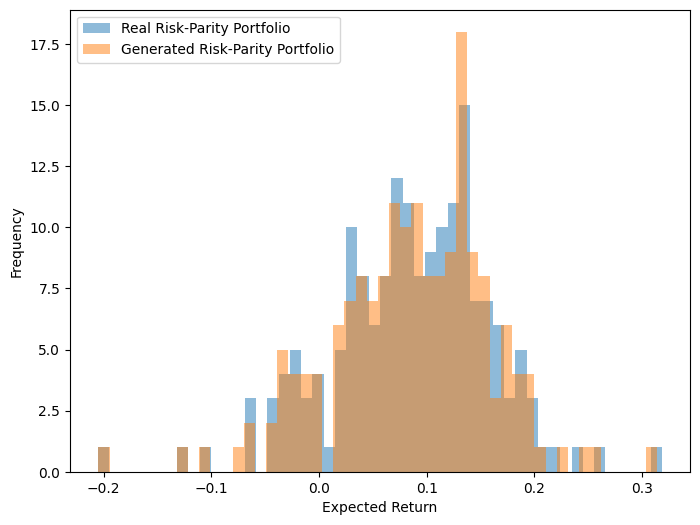

== 滚动收益统计量 (真实) ==
mean      0.085474
median    0.088479
std       0.074317
q1%      -0.113347
q5%      -0.034748
q10%     -0.014794
q25%      0.040321
dtype: float64
== 滚动收益统计量 (预测) ==
mean      0.085357
median    0.087089
std       0.074108
q1%      -0.113169
q5%      -0.035141
q10%     -0.014631
q25%      0.041682
dtype: float64


In [ ]:
roll_real = rolling_portfolio_returns(rets_real, weights_real, window=6)
roll_pred = rolling_portfolio_returns(rets_real, weights_generate, window=6)

plt.figure(figsize=(8,6))
plt.hist(roll_real, bins=50, alpha=0.5, label="Real Risk-Parity Portfolio")
plt.hist(roll_pred, bins=50, alpha=0.5, label="Generated Risk-Parity Portfolio")
plt.xlabel("Expected Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

def stats_summary(x):
    return pd.Series({
        "mean": x.mean(),
        "median": x.median(),
        "std": x.std(),
        "q1%": x.quantile(0.01),
        "q5%": x.quantile(0.05),
        "q10%": x.quantile(0.10),
        "q25%": x.quantile(0.25),
    })

print("== rolling return stats (real) ==")
print(stats_summary(roll_real))
print("== rolling return stats (predicted) ==")
print(stats_summary(roll_pred))

In [ ]:
def monthly_to_equal_days(df: pd.DataFrame, days_per_month: int = 30) -> pd.DataFrame:
    df = df.copy().sort_index()
    if isinstance(df.index, pd.PeriodIndex):
        months = df.index
        month_stamps = months.to_timestamp(how="start")
    else:
        month_stamps = pd.to_datetime(df.index)
        months = month_stamps.to_period("M")

    vals = df.values
    n_months, n_cols = vals.shape

    pieces = []
    idx_tuples = []
    steps = np.linspace(0.0, 1.0, days_per_month, endpoint=False)  # 0, 1/30, ..., 29/30

    for t in range(n_months - 1):
        v0, v1 = vals[t], vals[t + 1]
        block = v0 + np.outer(steps, (v1 - v0))               # (days_per_month, n_cols)
        pieces.append(block)
        idx_tuples += [(months[t], d) for d in range(1, days_per_month + 1)]

    last_block = np.repeat(vals[-1][None, :], days_per_month, axis=0)
    pieces.append(last_block)
    idx_tuples += [(months[-1], d) for d in range(1, days_per_month + 1)]

    out = pd.DataFrame(
        np.vstack(pieces),
        index=pd.MultiIndex.from_tuples(idx_tuples, names=["month", "day"]),
        columns=df.columns,
    )
    return out

daily_20 = monthly_to_equal_days(macro_pca_df.iloc[:, :6], days_per_month=20)

daily_20.index = daily_20.index.map(lambda x: f"{x[0]}-D{x[1]:02d}")
daily_20

,PC1,PC2,PC3,PC4,PC5,PC6
2010-09-D01,-14.087288,-4.866688,3.247625,1.573413,1.172293,-3.732404
2010-09-D02,-14.085136,-4.872291,3.266879,1.571695,1.152094,-3.733549
2010-09-D03,-14.082984,-4.877895,3.286133,1.569977,1.131895,-3.734693
2010-09-D04,-14.080831,-4.883499,3.305387,1.568259,1.111696,-3.735838
2010-09-D05,-14.078679,-4.889102,3.324642,1.566541,1.091497,-3.736982
...,...,...,...,...,...,...
2025-08-D16,13.834161,-1.639953,5.370937,1.545006,-2.064392,0.844473
2025-08-D17,13.834161,-1.639953,5.370937,1.545006,-2.064392,0.844473
2025-08-D18,13.834161,-1.639953,5.370937,1.545006,-2.064392,0.844473
2025-08-D19,13.834161,-1.639953,5.370937,1.545006,-2.064392,0.844473


In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

df = daily_20.iloc[:, :6].copy()
vals = df.to_numpy(dtype=np.float32)

window = 120
n_samples = vals.shape[0] - window + 1
assert n_samples > 0,

X_3d = sliding_window_view(vals, window_shape=window, axis=0)  # -> (n_samples, 120, 6)
X_3d.shape

# —— PC-prioritized flatten —— #
# (n_samples, 120, 6) -> (n_samples, 6, 120) -> (n_samples, 720)
X_pc_first = X_3d.reshape(n_samples, -1)

# PC1_t0..PC1_t119, PC2_t0..PC2_t119, ..., PC6_t0..PC6_t119
cols = [f"{col}_t{t}" for col in df.columns for t in range(window)]
sample_df_pc_first = pd.DataFrame(X_pc_first, columns=cols)

sample_df_pc_first.to_csv("diffusion_train_samples_pcfirst.csv", index=False)

print(sample_df_pc_first.shape)  # (n_samples, 720)
print("Saved to diffusion_train_samples_pcfirst.csv")

(3481, 720)
Saved to diffusion_train_samples_pcfirst.csv


In [ ]:
sample_df_pc_first

,PC1_t0,PC1_t1,PC1_t2,PC1_t3,PC1_t4,PC1_t5,PC1_t6,PC1_t7,PC1_t8,PC1_t9,...,PC6_t110,PC6_t111,PC6_t112,PC6_t113,PC6_t114,PC6_t115,PC6_t116,PC6_t117,PC6_t118,PC6_t119
0,-14.087288,-14.085135,-14.082984,-14.080832,-14.078679,-14.076527,-14.074375,-14.072223,-14.070070,-14.067918,...,-2.699189,-2.675564,-2.651939,-2.628314,-2.604688,-2.581063,-2.557438,-2.533813,-2.510188,-2.486563
1,-14.085135,-14.082984,-14.080832,-14.078679,-14.076527,-14.074375,-14.072223,-14.070070,-14.067918,-14.065766,...,-2.675564,-2.651939,-2.628314,-2.604688,-2.581063,-2.557438,-2.533813,-2.510188,-2.486563,-2.462938
2,-14.082984,-14.080832,-14.078679,-14.076527,-14.074375,-14.072223,-14.070070,-14.067918,-14.065766,-14.063614,...,-2.651939,-2.628314,-2.604688,-2.581063,-2.557438,-2.533813,-2.510188,-2.486563,-2.462938,-2.458972
3,-14.080832,-14.078679,-14.076527,-14.074375,-14.072223,-14.070070,-14.067918,-14.065766,-14.063614,-14.061461,...,-2.628314,-2.604688,-2.581063,-2.557438,-2.533813,-2.510188,-2.486563,-2.462938,-2.458972,-2.455007
4,-14.078679,-14.076527,-14.074375,-14.072223,-14.070070,-14.067918,-14.065766,-14.063614,-14.061461,-14.059309,...,-2.604688,-2.581063,-2.557438,-2.533813,-2.510188,-2.486563,-2.462938,-2.458972,-2.455007,-2.451042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,13.872689,13.867330,13.861970,13.856610,13.851251,13.839887,13.828524,13.817160,13.805797,13.794434,...,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473
3477,13.867330,13.861970,13.856610,13.851251,13.839887,13.828524,13.817160,13.805797,13.794434,13.783070,...,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473
3478,13.861970,13.856610,13.851251,13.839887,13.828524,13.817160,13.805797,13.794434,13.783070,13.771707,...,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473
3479,13.856610,13.851251,13.839887,13.828524,13.817160,13.805797,13.794434,13.783070,13.771707,13.760344,...,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473,0.844473


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv("diffusion_train_samples_pcfirst.csv")
X  = df.to_numpy(dtype="float32")
x_mean = X.mean(axis=0, keepdims=True)   # [1, 720]
x_std  = X.std(axis=0, keepdims=True) + 1e-6
X_norm = (X - x_mean) / x_std

assert X.ndim == 2 and X.shape[1] == 720, X.shape  # 720 = 120 * 6

class TimeSeries1DDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, i):
        x = self.X[i]          # shape: (720,)
        x = x[None, :]         # -> (1, 720)
        return x

dataset = TimeSeries1DDataset(X_norm)
loader  = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [ ]:
def marginal_prob_std(t, sigma):
    if isinstance(t, torch.Tensor):
        t = t.clone().detach()
    else:
        t = torch.tensor(t, device='cpu')
    return torch.sqrt((sigma ** (2 * t) - 1.) / (2. * np.log(sigma)))

def diffusion_coeff(t, sigma):
    return sigma ** t

def loss_fn_1d(model, x, marginal_prob_std_fn, diffusion_coeff_fn, eps=1e-5, num_steps=500):
    B = x.shape[0]
    device = x.device

    # t ~ U(eps, 1]
    t = torch.rand(B, device=device) * (1. - eps) + eps
    z = torch.randn_like(x)

    std = marginal_prob_std_fn(t)[:, None, None]     # [B,1,1]
    x_perturbed = x + z * std

    timesteps = (t * (num_steps - 1)).long()         # [B]

    score_pred = model(x_perturbed, timesteps).sample  # [B,1,L]

    # DSM Loss: E|| score*std + z ||^2
    loss = torch.mean(torch.sum((score_pred * std + z)**2, dim=(1,2))[:, None, None])
    return loss


def Euler_Maruyama_sampler_1d(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                              length=720, batch_size=64, num_steps=500,
                              device='cuda', eps=1e-5):

    t_init = torch.ones(batch_size, device=device)
    std0   = marginal_prob_std_fn(t_init)[:, None, None]          # [B,1,1]
    x      = torch.randn(batch_size, 1, length, device=device) * std0

    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size  = time_steps[0] - time_steps[1]

    with torch.no_grad():
      for time in time_steps:
          batch_t  = torch.full((batch_size,), time, device=device)
          g        = diffusion_coeff_fn(batch_t)[:, None, None]     # [B,1,1]
          t_index  = (batch_t * (num_steps - 1)).long()
          score    = score_model(x, t_index).sample                 # [B,1,L]

          mean_x = x - (g**2) * score * step_size
          x      = mean_x + torch.sqrt(step_size) * g * torch.randn_like(x)

    return x

In [ ]:
model = UNet1DModel(
    sample_size=736,
    in_channels=1,
    out_channels=1,
    layers_per_block=3,         # 每个尺度 3 个残差层（更强）
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock1D",          # 720  -> 360
        "AttnDownBlock1D",      # 360  -> 180  + Self-Attn
        "DownBlock1D",      # 180  -> 90   + Self-Attn
        "AttnDownBlock1D",          # 90   -> 45
    ),
    up_block_types=(
        "AttnUpBlock1D",            # 45   -> 90
        "UpBlock1D",        # 180  -> 360  + Self-Attn
        "AttnUpBlock1D",            # 360  -> 720
        "UpBlock1D",
    ),
).to(device)


In [ ]:
import torch.nn.functional as F

sigma = 15.0
marginal_prob_std_fn = lambda t: marginal_prob_std(t, sigma)
diffusion_coeff_fn   = lambda t: diffusion_coeff(t, sigma)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_steps = 1000
epochs    = 30

model.train()
for ep in range(1, epochs+1):
    running = 0.0
    for x in loader:
        x = x.to(device)      # [B,1,720】
        pad_len = 736 - x.shape[-1]
        if pad_len > 0:
            x = F.pad(x, (0, pad_len))
        loss = loss_fn_1d(model, x, marginal_prob_std_fn, diffusion_coeff_fn, num_steps=num_steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item()
    print(f"[Epoch {ep:03d}] loss={running/len(loader):.6f}")

[Epoch 001] loss=1159.105118
[Epoch 002] loss=558.722738
[Epoch 003] loss=522.463064
[Epoch 004] loss=495.048497
[Epoch 005] loss=480.410435
[Epoch 006] loss=471.180271
[Epoch 007] loss=460.870893
[Epoch 008] loss=453.626387
[Epoch 009] loss=447.906056
[Epoch 010] loss=440.308534
[Epoch 011] loss=434.709320
[Epoch 012] loss=429.187738
[Epoch 013] loss=423.777289
[Epoch 014] loss=419.428754
[Epoch 015] loss=417.584721
[Epoch 016] loss=413.379992
[Epoch 017] loss=409.503718
[Epoch 018] loss=409.931450
[Epoch 019] loss=406.265563
[Epoch 020] loss=408.351669
[Epoch 021] loss=402.942803
[Epoch 022] loss=401.010325
[Epoch 023] loss=400.520930
[Epoch 024] loss=399.096524
[Epoch 025] loss=397.409236
[Epoch 026] loss=396.668883
[Epoch 027] loss=396.502422
[Epoch 028] loss=395.392527
[Epoch 029] loss=394.665556
[Epoch 030] loss=394.323533


In [ ]:
def sample_many(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                length=736, total=512, chunk=64, num_steps=1000,
                device='cuda', eps=1e-5, use_fp16=True):
    outs = []
    score_model.eval()
    for i in range(0, total, chunk):
        bs = min(chunk, total - i)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            x = Euler_Maruyama_sampler_1d(
                score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                length=length, batch_size=bs, num_steps=num_steps,
                device=device, eps=eps
            )
        x = x[..., :720]
        x = (x.cpu() * x_std + x_mean) // 10
        outs.append(x.cpu())
        del x
    return torch.cat(outs, dim=0)

set_seed(42)

samples = sample_many(
    score_model=model,
    marginal_prob_std_fn=marginal_prob_std_fn,
    diffusion_coeff_fn=diffusion_coeff_fn,
    length=736,
    total=180,
    chunk=32,
    num_steps=1000,
    device=device,
    use_fp16=True
)
print(samples.shape)

/tmp/ipython-input-3849085651.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = (x.cpu() * x_std + x_mean) // 10


torch.Size([180, 1, 720])


Selected days (1-based): [1, 21, 41, 61, 81, 101]
Mean cum (6 days): 0.3429921
Std  cum (6 days): 0.3026489


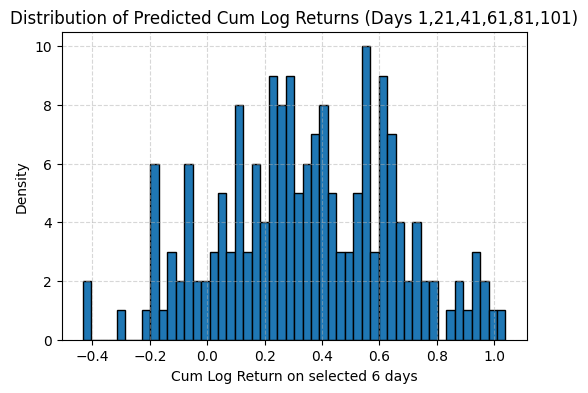

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


select_days_1based = [1, 21, 41, 61, 81, 101]
idx = torch.tensor([d-1 for d in select_days_1based], device=device)   # [6]

with torch.no_grad():
    # [B, 1, 720] -> [B, 120, 6]
    X_synth = samples.squeeze(1).to(device)          # [B, 720]
    B = X_synth.shape[0]
    x_120x6 = X_synth.reshape(B, 6, 120).transpose(1, 2)
    #x_120x6 = X_synth.view(B, 120, 6)                # [B, 120, 6]

    x_pick = x_120x6.index_select(dim=1, index=idx)  # [B, 6, 6]

    y_pred_std_pick = model_FNN(x_pick.reshape(-1, 6)).reshape(B, len(idx))

    y_pred_pick = y_pred_std_pick * y_std + y_mean   # [B, 6]

    y_pred_cum_pick = y_pred_pick.sum(dim=1)         # [B]

cumrets = y_pred_cum_pick.detach().cpu().numpy()     # (B,)

print("Selected days (1-based):", select_days_1based)
print("Mean cum (6 days):", cumrets.mean())
print("Std  cum (6 days):",  cumrets.std())

plt.figure(figsize=(6,4))
plt.hist(cumrets, bins=50, edgecolor='black')
plt.xlabel("Cum Log Return on selected 6 days")
plt.ylabel("Density")
plt.title("Distribution of Predicted Cum Log Returns (Days 1,21,41,61,81,101)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()